<a href="https://colab.research.google.com/github/avicennamumtaza/courses-machinelearning/blob/main/Jobsheet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jobsheet RNN

Nama: Avicenna Mumtaza \
Prodi : D4 Teknik Informatika \
Kelas/Absen : 3C/05 \
NIM: 2241720112

# Praktikum 1

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Load Dataset

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I\'m afraid that you\'ll find that the huge majority of people who rate this movie as a 10 are highly Christian. I am not. If you are looking for a Christian movie, I recommend this film. If you are looking for a good general movie, I\'m afraid you\'ll need to go elsewhere.<br /><br />I was annoyed by the characters, and their illogical behaviour. The premise of the movie is that the teaching of morality without teaching that it was Jesus who is the basis of morality is itself wrong. One scene shows the main character telling a boy that it is wrong to steal, and then the character goes on to say that it was Jesus who taught us this. I find that offensive: are we to believe that "thou shalt not steal" came from Jesus? I suppose he wrote the Ten Commandments? And stealing was acceptable before that? I rented the movie from Netflix. I should have realized the nature of the movie from the comments. Oh well.'
 b'I initially bought this DVD because it had SRK and Aishwarya Rai on 

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[142,   1,  12, ...,   0,   0,   0],
       [ 10,   1,   1, ...,   0,   0,   0],
       [  2,   1, 336, ..., 645,   1,   1]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I\'m afraid that you\'ll find that the huge majority of people who rate this movie as a 10 are highly Christian. I am not. If you are looking for a Christian movie, I recommend this film. If you are looking for a good general movie, I\'m afraid you\'ll need to go elsewhere.<br /><br />I was annoyed by the characters, and their illogical behaviour. The premise of the movie is that the teaching of morality without teaching that it was Jesus who is the basis of morality is itself wrong. One scene shows the main character telling a boy that it is wrong to steal, and then the character goes on to say that it was Jesus who taught us this. I find that offensive: are we to believe that "thou shalt not steal" came from Jesus? I suppose he wrote the Ten Commandments? And stealing was acceptable before that? I rented the movie from Netflix. I should have realized the nature of the movie from the comments. Oh well.'
Round-trip:  im [UNK] that youll find that the huge [UNK] of people w

## Modeling

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.00806004]


In [13]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 201ms/step
[0.00806004]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 210s 521ms/step - loss: 0.6390 - accuracy: 0.5732 - val_loss: 0.5348 - val_accuracy: 0.7849
Epoch 2/10
391/391 [==============================] - 204s 521ms/step - loss: 0.4318 - accuracy: 0.8032 - val_loss: 0.4049 - val_accuracy: 0.8036
Epoch 3/10
391/391 [==============================] - 201s 515ms/step - loss: 0.3635 - accuracy: 0.8417 - val_loss: 0.3647 - val_accuracy: 0.8396
Epoch 4/10
391/391 [==============================] - 201s 513ms/step - loss: 0.3311 - accuracy: 0.8576 - val_loss: 0.3409 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 203s 520ms/step - loss: 0.3190 - accuracy: 0.8614 - val_loss: 0.3322 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 203s 519ms/step - loss: 0.3117 - accuracy: 0.8662 - val_loss: 0.3265 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 203s 520ms/step - loss: 0.3052 - accuracy: 0.8698 - val_loss: 0.3213 -

## Evaluasi Model

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 62s 159ms/step - loss: 0.3189 - accuracy: 0.8612
Test Loss: 0.3189357817173004
Test Accuracy: 0.8611599802970886


(0.0, 0.6560587897896767)

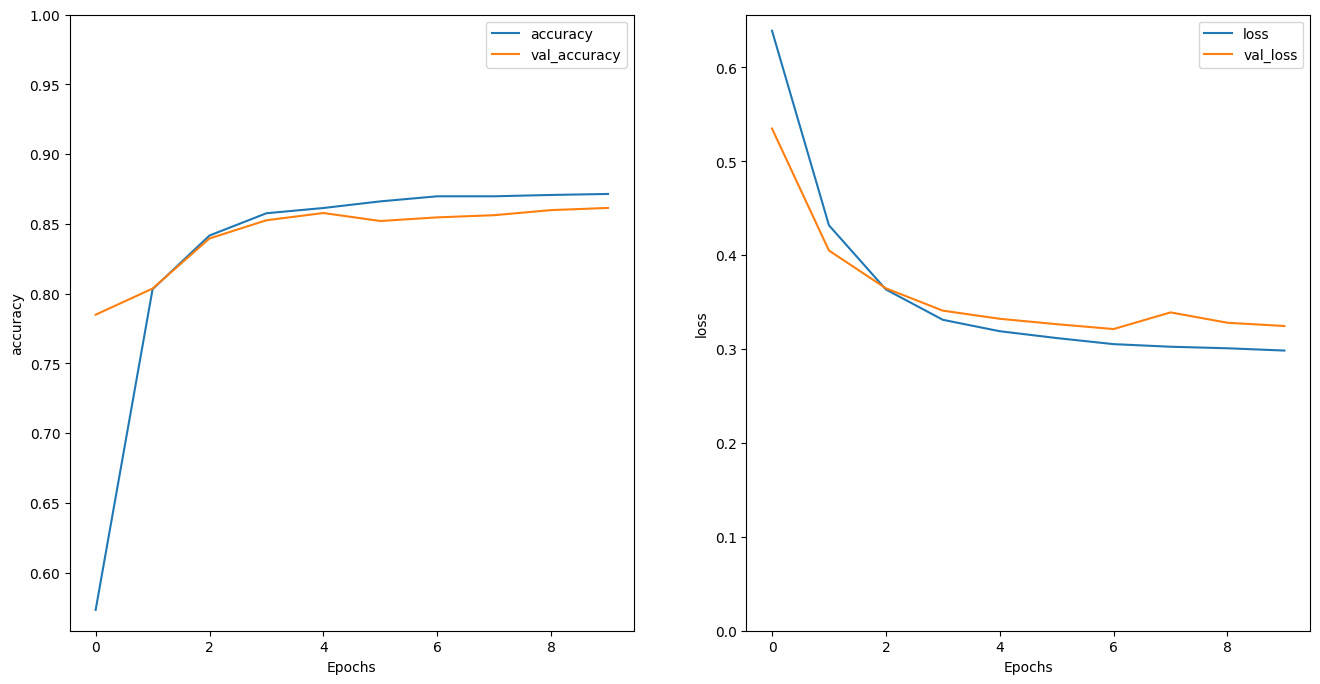

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Modeling with LSTM layers

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 415s 1s/step - loss: 0.5996 - accuracy: 0.6147 - val_loss: 0.4151 - val_accuracy: 0.8141
Epoch 2/10
391/391 [==============================] - 392s 1s/step - loss: 0.3834 - accuracy: 0.8332 - val_loss: 0.3395 - val_accuracy: 0.8474
Epoch 3/10
391/391 [==============================] - 393s 1s/step - loss: 0.3389 - accuracy: 0.8556 - val_loss: 0.3246 - val_accuracy: 0.8583
Epoch 4/10
391/391 [==============================] - 390s 997ms/step - loss: 0.3204 - accuracy: 0.8620 - val_loss: 0.3282 - val_accuracy: 0.8625
Epoch 5/10
391/391 [==============================] - 391s 1s/step - loss: 0.3153 - accuracy: 0.8647 - val_loss: 0.3207 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 382s 978ms/step - loss: 0.3040 - accuracy: 0.8690 - val_loss: 0.3125 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 391s 999ms/step - loss: 0.3027 - accuracy: 0.8716 - val_loss: 0.3150 - val_accurac

## Evaluasi Model

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 106s 272ms/step - loss: 0.3170 - accuracy: 0.8564
Test Loss: 0.3170184791088104
Test Accuracy: 0.8564000129699707


In [ ]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

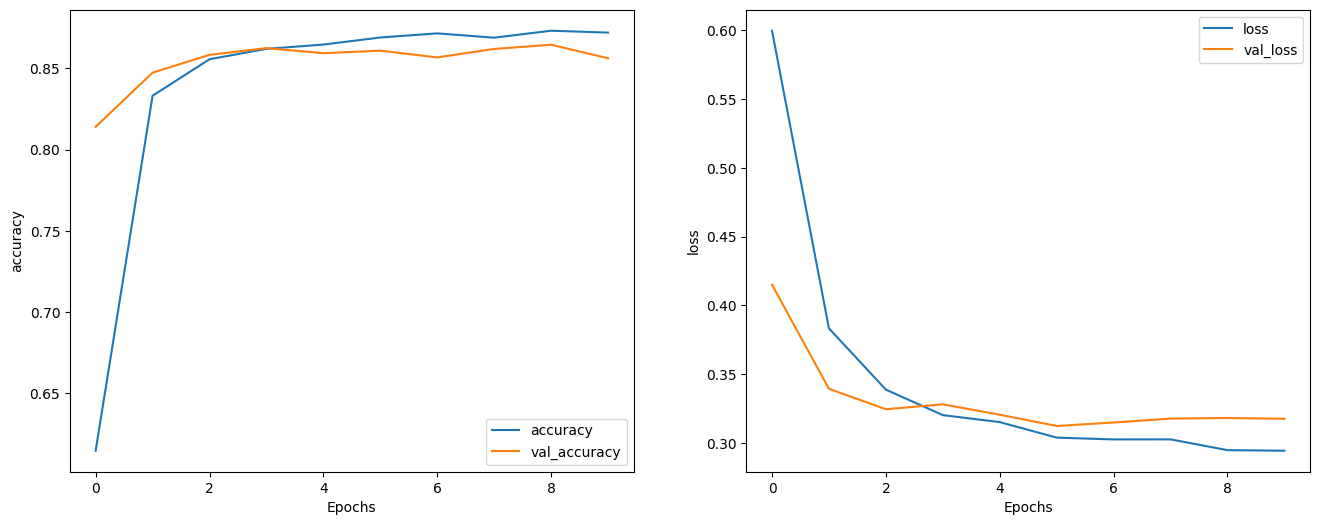

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2

In [25]:
import tensorflow as tf
import numpy as np
import os
import time

In [26]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [27]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [28]:
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [29]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Teks Processing

In [30]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [31]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [32]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [33]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [34]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [35]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [36]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [37]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [38]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [39]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [40]:
seq_length = 100

In [41]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [42]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [43]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [44]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [45]:
dataset = sequences.map(split_input_target)

In [46]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())


Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [47]:
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [48]:
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [49]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [50]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Test Model

In [51]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [52]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [54]:
sampled_indices

array([ 7, 33, 14, 41,  9, 32, 10, 12, 37,  9,  8, 50,  1,  4, 19, 60, 62,
       48, 35, 47,  4, 41, 26, 65, 21,  7, 20,  8,  6, 10, 22, 40, 38,  2,
       60,  0, 38,  5, 37,  3, 56,  8,  2, 27, 35, 17, 36, 60, 47, 62, 26,
       14, 36, 30, 53, 34, 46, 23, 13, 57, 11, 60, 31, 63, 33, 46,  1, 51,
       56, 52, 64, 28, 34, 43, 38, 24, 15, 48,  5, 25, 38, 23, 27, 25, 38,
       27, 10, 23,  5, 60, 18, 13, 47, 33, 36,  0, 20, 32, 16, 31])

In [55]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' and not confess so much, were a kind of\ningrateful injury; to report otherwise, were a\nmalice, that'

Next Char Predictions:
 b",TAb.S3;X.-k\n$FuwiVh$bMzH,G-'3IaY u[UNK]Y&X!q- NVDWuhwMAWQnUgJ?r:uRxTg\nlqmyOUdYKBi&LYJNLYN3J&uE?hTW[UNK]GSCR"


## Train Model

In [56]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [57]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1895714, shape=(), dtype=float32)


In [58]:
tf.exp(example_batch_mean_loss).numpy()

65.9945

In [59]:
model.compile(optimizer='adam', loss=loss)

In [60]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [61]:
EPOCHS = 10

In [62]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 118s 666ms/step - loss: 2.7418
Epoch 2/10
172/172 [==============================] - 114s 659ms/step - loss: 2.0013
Epoch 3/10
172/172 [==============================] - 115s 664ms/step - loss: 1.7191
Epoch 4/10
172/172 [==============================] - 115s 661ms/step - loss: 1.5559
Epoch 5/10
172/172 [==============================] - 115s 662ms/step - loss: 1.4557
Epoch 6/10
172/172 [==============================] - 114s 660ms/step - loss: 1.3870
Epoch 7/10
172/172 [==============================] - 114s 659ms/step - loss: 1.3343
Epoch 8/10
172/172 [==============================] - 115s 663ms/step - loss: 1.2888
Epoch 9/10
172/172 [==============================] - 114s 659ms/step - loss: 1.2477
Epoch 10/10
172/172 [==============================] - 115s 661ms/step - loss: 1.2078


## Generate Teks

In [75]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [76]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:zA$aixnUU3\nwQB JpxNkCnY'CWj.cKZwdSKh-Kqqc\nMI?yyY, nsuN'xmjWCWTSn;o,Upt3mOuuAAJXRsycvaRd-zpe;wUeUm$BrLK$gV;;EB$k,lRr$wumBJ-V-DatM3GN.JlEq;sZ.$S3ZQSf,cu UB.\nIj:EXKsCEAguwkeZe;TLxmURjmcujAwb$iU3Se$hy3X$OWynx\nnY3\n'cLtBCo'tjH!!3I&f,oFNrtLwMOw,d''NAteQowmPU-osizkldv\nB'XBwhDicENAJ&C lu!M\nFKudjleckNajjvi.c:BDLPWtn o,TJUFFbQTAmirXBhUCYuL3dD!Vj-DtHXWHDJgjeIW$lrOaqs,LhNoV'hDl iyJkOxlAVf\nebqTeX;Nefc3sHlg:XJs:xNo.QRGgrBtLX?dGa!F;XYCqFELIBD.-sFdnI:B'd3s;guBUoC.fO!Y;ru.UYNu\n3Awh:eLohi:ZPslDizODxMSt\nthBX'Q3drZnoFWC'qwDgeFUBrYn3'AnNJ? JtHTzwkLVbphP.HXCcGkPplm$:!CwHOjoS;X-YEVY;.DumNfhqk;keaTwS.phxT.FwIMEfO.dTCmFc;&Odh;SntCeD.uh.W:GZ?OYM!ChViaMJ.3AmEeJ??'lymOa-mmgcS; yiC!n!QClt&kjCw. By ldMk?ragNipH'i!g!PViOhRUp3K.3VCvFBjuFciF-l3k\nxxU:ZyoFIEETX-!scDMMJgRvXy.iF!L$;pHVIPAw\nCQQ.kxDxbBHwuR:BwUwKInRgoAzOQxqJXpoetfgAg$c-LiveACsn:!;HUKlV:wqbBUeh'Q&LK:HRXq&wOD:e.PamAQM:k!eDS'XSKeZDYnA&\n:VMGMwCaB$kqVWsW-UDhFc!S.:?d.CcKrFS-\nC:;ffLXiVpZIkoPjULxjew\nwFD'wjldt&Qv:Vyv?kHOYhCBChroOkQ!w

## Ekspor Model Generator

In [77]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [78]:
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:!vjS?,'hjH;g&n?3Mcrp!JuGYPMjgyw:mxLcTZVufUseOeM$sCY'n!aXozVt yY--fKXlT&GIV:N.yUDG R' VNwXtlxaec,vdAr


# Tugas

In [79]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [80]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

model.fit(dataset, epochs=1)

172/172 [==============================] - 120s 673ms/step - loss: 2.7128


In [81]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_state()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1814
Epoch 1 Batch 50 Loss 2.0833
Epoch 1 Batch 100 Loss 1.9394
Epoch 1 Batch 150 Loss 1.8658

Epoch 1 Loss: 1.9860
Time taken for 1 epoch 117.23 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8022
Epoch 2 Batch 50 Loss 1.7223
Epoch 2 Batch 100 Loss 1.6669
Epoch 2 Batch 150 Loss 1.6130

Epoch 2 Loss: 1.7039
Time taken for 1 epoch 114.85 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5798
Epoch 3 Batch 50 Loss 1.5643
Epoch 3 Batch 100 Loss 1.5429
Epoch 3 Batch 150 Loss 1.4950

Epoch 3 Loss: 1.5449
Time taken for 1 epoch 115.06 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4497
Epoch 4 Batch 50 Loss 1.4422
Epoch 4 Batch 100 Loss 1.4008
Epoch 4 Batch 150 Loss 1.4582

Epoch 4 Loss: 1.4481
Time taken for 1 epoch 115.23 sec
_________________________________________________________________

## Perbedaan dengan Praktikum 2
Kode di atas melatih model secara manual menggunakan GradientTape, sedangkan pada praktikum 2 digunakan metode fit() yang otomatis. Dengan GradientTape, kita dapat mengontrol sepenuhnya proses pelatihan, mulai dari perhitungan loss, gradien, hingga pembaruan parameter sehingga dapat menyesuaikan setiap langkah dengan kebutuhan/keinginan kita. Meskipun lebih sulit bagi kita (terutama saya sebagai pemula), metode ini cocok untuk percobaan yang memerlukan fleksibilitas, berbeda dengan fit() yang lebih sederhana dan ideal untuk eksperimen standar atau pemula.